### Importing libraries

In [1]:
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary

from matplotlib import pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import os
import random
import shutil
import time
from datetime import datetime
from ipywidgets import interact, Dropdown, widgets
from IPython.display import display


%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
%reload_ext watermark 
%watermark -v -m -p numpy,matplotlib,seaborn,sklearn,pandas,torch,torchvision

Python implementation: CPython
Python version       : 3.12.7
IPython version      : 8.27.0

numpy      : 1.26.4
matplotlib : 3.9.2
seaborn    : 0.13.2
sklearn    : 1.5.1
pandas     : 2.2.3
torch      : 2.5.1+cu124
torchvision: 0.20.1

Compiler    : MSC v.1929 64 bit (AMD64)
OS          : Windows
Release     : 11
Machine     : AMD64
Processor   : Intel64 Family 6 Model 186 Stepping 2, GenuineIntel
CPU cores   : 20
Architecture: 64bit



In [3]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [4]:
random_seed = 42
batch_size = 20

device= torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

## Loading the Sparrow v/s Swan dataset

In [5]:
# Define the transformations (resize and conversion to tensor)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 224x224 for consistency
    transforms.ToTensor()           # Convert to tensor for processing
])

# Set the paths for the training and testing directories
output_dir_base = '../data'
train_dir = os.path.join(output_dir_base, 'train')
test_dir = os.path.join(output_dir_base, 'test')

# Ensure the directories exist
if not os.path.exists(train_dir) or not os.path.exists(test_dir):
    raise FileNotFoundError("Training or testing directory not found.")

# Load the training dataset
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)

# Load the testing dataset
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

# Print the size of training and testing datasets
print(f'Total training samples: {len(train_dataset)}')
print(f'Total testing samples: {len(test_dataset)}')

# Print class labels (to confirm that subdirectories are used as class labels)
print(f'Class labels: {train_dataset.classes}')

# Verify class-to-index mapping
print("Class-to-index mapping: ")
print("Training dataset: ", train_dataset.class_to_idx)
print("Testing dataset: ", test_dataset.class_to_idx)

Total training samples: 160
Total testing samples: 40
Class labels: ['sparrow', 'swan']
Class-to-index mapping: 
Training dataset:  {'sparrow': 0, 'swan': 1}
Testing dataset:  {'sparrow': 0, 'swan': 1}


Creating the train and test data loaders

In [6]:
train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False)

print(f'Number of training batches: {len(train_loader)}')
print(f'Number of testing batches: {len(test_loader)}')

images, labels = next(iter(train_loader))
print(f'\nBatch of images with shape: {images.shape}')
print(f'Batch of labels with shape: {labels.shape}')

Number of training batches: 8
Number of testing batches: 2

Batch of images with shape: torch.Size([20, 3, 224, 224])
Batch of labels with shape: torch.Size([20])


## MLP Model

In [7]:
import torch
import torch.nn as nn

class MLPVGG16ComparableBinary(nn.Module):
    def __init__(self):
        super(MLPVGG16ComparableBinary, self).__init__()

        # Input size (224x224x3) flattened
        input_size = 224 * 224 * 3
        
        # Define the layers with approximated parameters from VGG16
        self.fc1 = nn.Linear(input_size, 2000)  # First hidden layer
        self.fc2 = nn.Linear(2000, 1000)        # Second hidden layer
        self.fc3 = nn.Linear(1000, 1)           # Output layer
        
        # Dropout layer for regularization
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input image (batch_size, 224*224*3)
        
        # Pass through layers with ReLU activation
        x = self.dropout(torch.relu(self.fc1(x)))  
        x = self.dropout(torch.relu(self.fc2(x)))  
        x = torch.sigmoid(self.fc3(x))

        return x

# Create the model instance
model = MLPVGG16ComparableBinary()

# Print the model to verify the architecture
print(model)

# Verify the number of parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")


MLPVGG16ComparableBinary(
  (fc1): Linear(in_features=150528, out_features=2000, bias=True)
  (fc2): Linear(in_features=2000, out_features=1000, bias=True)
  (fc3): Linear(in_features=1000, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)
Total number of parameters: 303060001


In [8]:
model = MLPVGG16ComparableBinary()
model.to(device)

# Define loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss for binary classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

In [9]:
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 2000]     301,058,000
           Dropout-2                 [-1, 2000]               0
            Linear-3                 [-1, 1000]       2,001,000
           Dropout-4                 [-1, 1000]               0
            Linear-5                    [-1, 1]           1,001
Total params: 303,060,001
Trainable params: 303,060,001
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 0.05
Params size (MB): 1156.08
Estimated Total Size (MB): 1156.70
----------------------------------------------------------------


In [10]:
# Training function
def train_model(model, train_loader, val_loader, num_epochs, device):
    model = model.to(device)
    epoch_train_losses, epoch_test_losses = [], []
    epoch_train_accuracies, epoch_test_accuracies = [], []

    for epoch in range(1, num_epochs+1):
        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels.float().view(-1, 1))
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)
        train_accuracy = correct_train / total_train
        epoch_train_losses.append(train_loss)
        epoch_train_accuracies.append(train_accuracy)
        
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels.float().view(-1, 1))
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct_val += (predicted == labels).sum().item()
                total_val += labels.size(0)
            val_accuracy = correct_val / total_val
            epoch_test_losses.append(val_loss)
            epoch_test_accuracies.append(val_accuracy)

        # Display metrics
        print(f"Epoch [{epoch}/{num_epochs}] -> "
              f"Train Loss: {train_loss/len(train_loader):.4f}, Train Acc: {train_accuracy:.4f}, "
              f"Val Loss: {val_loss/len(val_loader):.4f}, Val Acc: {val_accuracy:.4f}")
        
    return model, epoch_train_losses, epoch_test_losses, epoch_train_accuracies, epoch_test_accuracies



def predict(model, data_loader, device):
    model.to(device) 
    all_preds, all_labels = [], []
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device) 
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy()) 
            all_labels.extend(labels.cpu().numpy())
            correct += torch.sum(preds == labels.data)
            total += labels.size(0)
    accuracy = correct.double() / total
    return accuracy.item(), np.array(all_preds), np.array(all_labels)

In [11]:
def plot_metrics(train_losses, test_losses, train_accuracies, test_accuracies, title_suffix):
    # Plotting the losses and accuracies
    plt.figure(figsize=(12, 5))
    plt.suptitle(f"Training and Testing Metrics ({title_suffix})", fontsize=16)
    
    # Plot Loss vs. Epochs
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss', color='blue', marker='o')
    plt.plot(test_losses, label='Test Loss', color='red', marker='o')
    plt.title(f'Loss vs. Epochs ({title_suffix})')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.xticks(range(len(train_losses)))
    
    # Plot Accuracy vs. Epochs
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy', color='blue', marker='o')
    plt.plot(test_accuracies, label='Test Accuracy', color='red', marker='o')
    plt.title(f'Accuracy vs. Epochs ({title_suffix})')
    plt.ylim(0, 1.1)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.xticks(range(len(train_accuracies)))
    
    plt.tight_layout()
    plt.show()


def plot_confusion_matrix(model, test_loader, title_suffix='', device='cpu'):
    model.eval()
    acc, preds, labels = predict(model, test_loader, device)
    
    cm = confusion_matrix(labels, preds)
    plt.figure(figsize=(4, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
                xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'Confusion Matrix (Accuracy: {acc:.4f}) - {title_suffix}')
    plt.tight_layout()
    plt.show()



def plot_test_predictions_grid(model, test_loader, num_images=40, grid_size=(5, 8), title_suffix='', device='cpu', writer=None, show_plot=True):
    model.eval()
    images, true_labels, predicted_labels = [], [], []

    with torch.no_grad():
        for inputs, labels in test_loader:
            if len(images) >= num_images:
                break
            inputs, labels = inputs.to(device), labels.to(device)
            # Forward pass
            outputs = model(inputs)
            
            # Convert softmax probabilities to class indices
            preds = torch.argmax(outputs, dim=1).cpu().numpy()

            # Store images and labels for visualization
            images.extend(inputs.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(preds)


    # Accuracy calculation
    true_labels = np.array(true_labels)
    predicted_labels = np.array(predicted_labels).squeeze().astype(int)
    correct = (true_labels == predicted_labels).sum()
    total = true_labels.shape[0]
    accuracy = correct / total
    print(f"Accuracy on {total} test images: {accuracy:.4f}")

    # Create a figure for the image grid
    fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=(16, 10))
    fig.suptitle("True and Predicted Labels - " + title_suffix, fontsize=16)
    fig.subplots_adjust(hspace=0.6, wspace=0.3)

    for idx, ax in enumerate(axes.flat):
        if idx < len(images):
            
            img = images[idx].transpose(1, 2, 0)  # (C, H, W) -> (H, W, C)

            ax.imshow(img)
            ax.axis("off")
            true_label = int(true_labels[idx])
            predicted_label = int(predicted_labels[idx].squeeze())
            ax.set_title(f"True: {true_label} | Pred: {predicted_label}",
                         color="green" if true_label == predicted_label else "red")
        else:
            ax.axis("off")  # Hide any empty subplots

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    if show_plot:
        plt.show()

    # Log the grid of images to TensorBoard
    if writer:
        writer.add_figure("Test Predictions Grid", fig)

    # Return the true and predicted labels for further evaluation
    return true_labels, predicted_labels

In [12]:
# Train the model
num_epochs = 10
model, train_losses, test_losses, train_accuracies, test_accuracies = train_model(model, train_loader, test_loader, num_epochs, device)


Epoch [1/10] -> Train Loss: 46.3373, Train Acc: 0.5000, Val Loss: 50.0000, Val Acc: 0.5000
Epoch [2/10] -> Train Loss: 50.0000, Train Acc: 0.5000, Val Loss: 50.0000, Val Acc: 0.5000
Epoch [3/10] -> Train Loss: 50.0000, Train Acc: 0.5000, Val Loss: 50.0000, Val Acc: 0.5000
Epoch [4/10] -> Train Loss: 50.0000, Train Acc: 0.5000, Val Loss: 50.0000, Val Acc: 0.5000
Epoch [5/10] -> Train Loss: 50.0000, Train Acc: 0.5000, Val Loss: 50.0000, Val Acc: 0.5000
Epoch [6/10] -> Train Loss: 50.0000, Train Acc: 0.5000, Val Loss: 50.0000, Val Acc: 0.5000
Epoch [7/10] -> Train Loss: 50.0000, Train Acc: 0.5000, Val Loss: 50.0000, Val Acc: 0.5000
Epoch [8/10] -> Train Loss: 50.0000, Train Acc: 0.5000, Val Loss: 50.0000, Val Acc: 0.5000
Epoch [9/10] -> Train Loss: 50.0000, Train Acc: 0.5000, Val Loss: 50.0000, Val Acc: 0.5000
Epoch [10/10] -> Train Loss: 50.0000, Train Acc: 0.5000, Val Loss: 50.0000, Val Acc: 0.5000


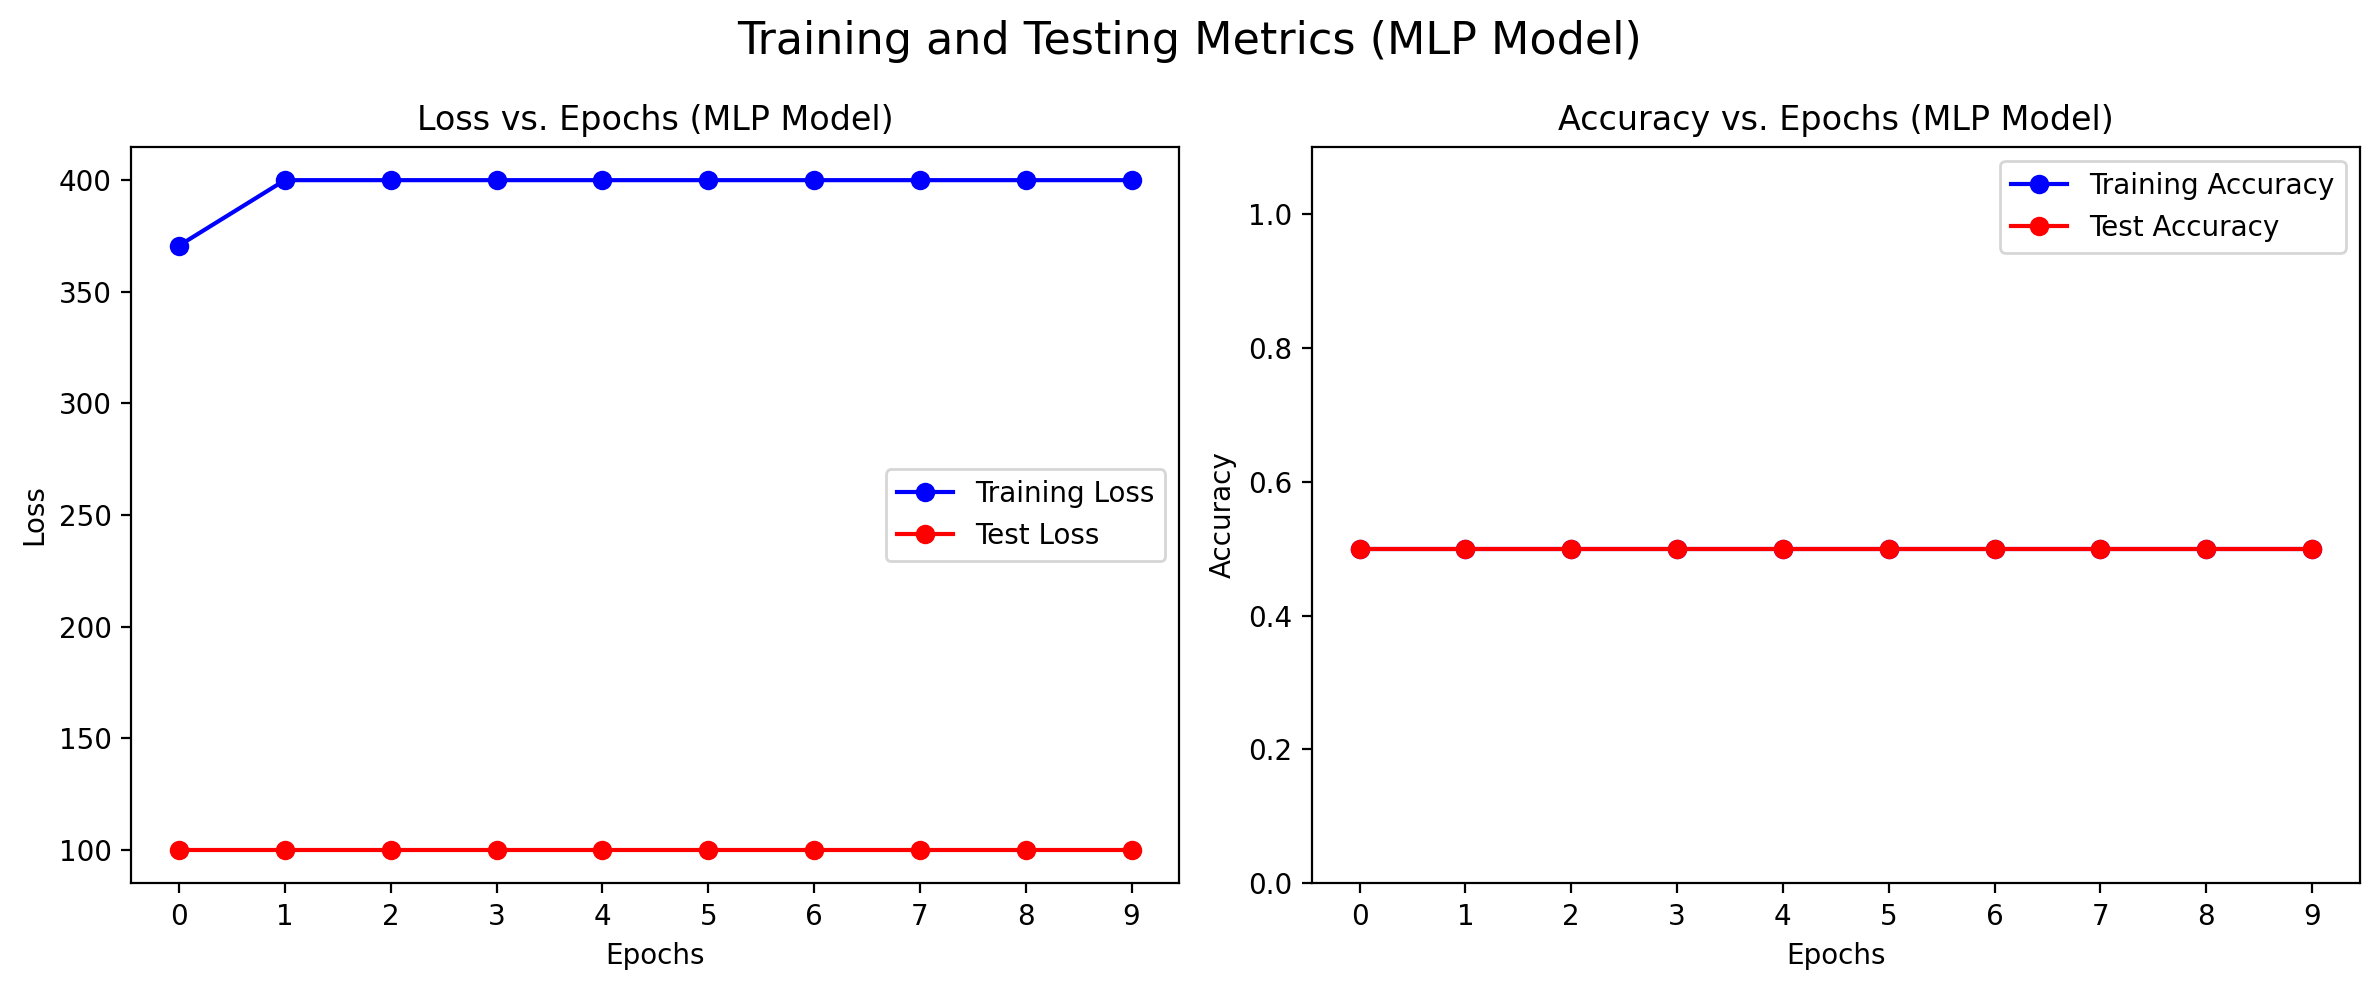

In [13]:
# Plot the training and testing metrics
plot_metrics(train_losses, test_losses, train_accuracies, test_accuracies, "MLP Model")

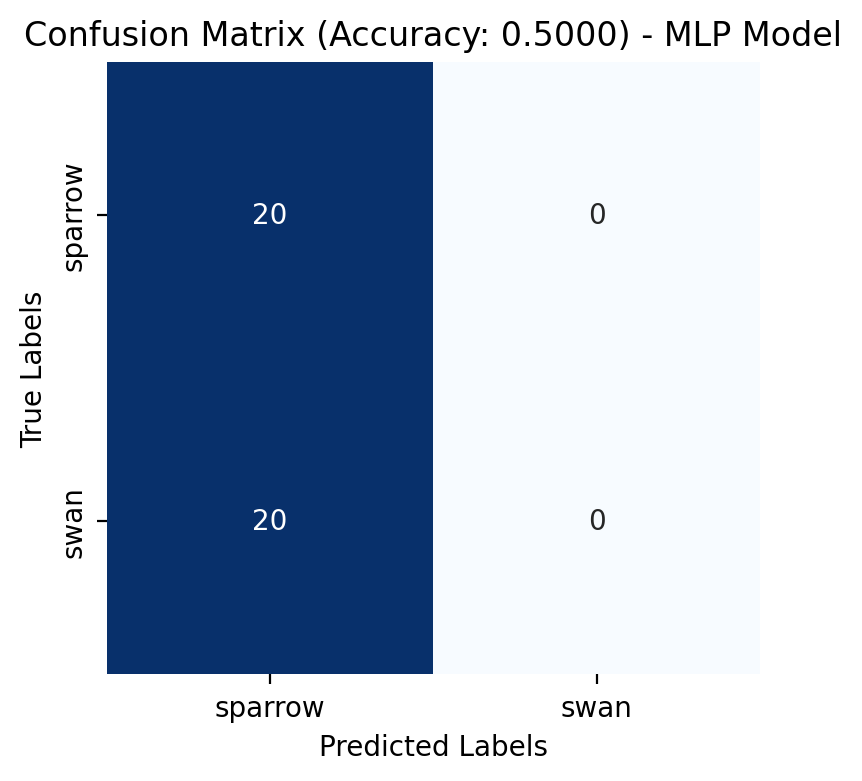

In [14]:
# Plot the confusion matrix
plot_confusion_matrix(model, test_loader, "MLP Model", device)

Accuracy on 40 test images: 0.5000


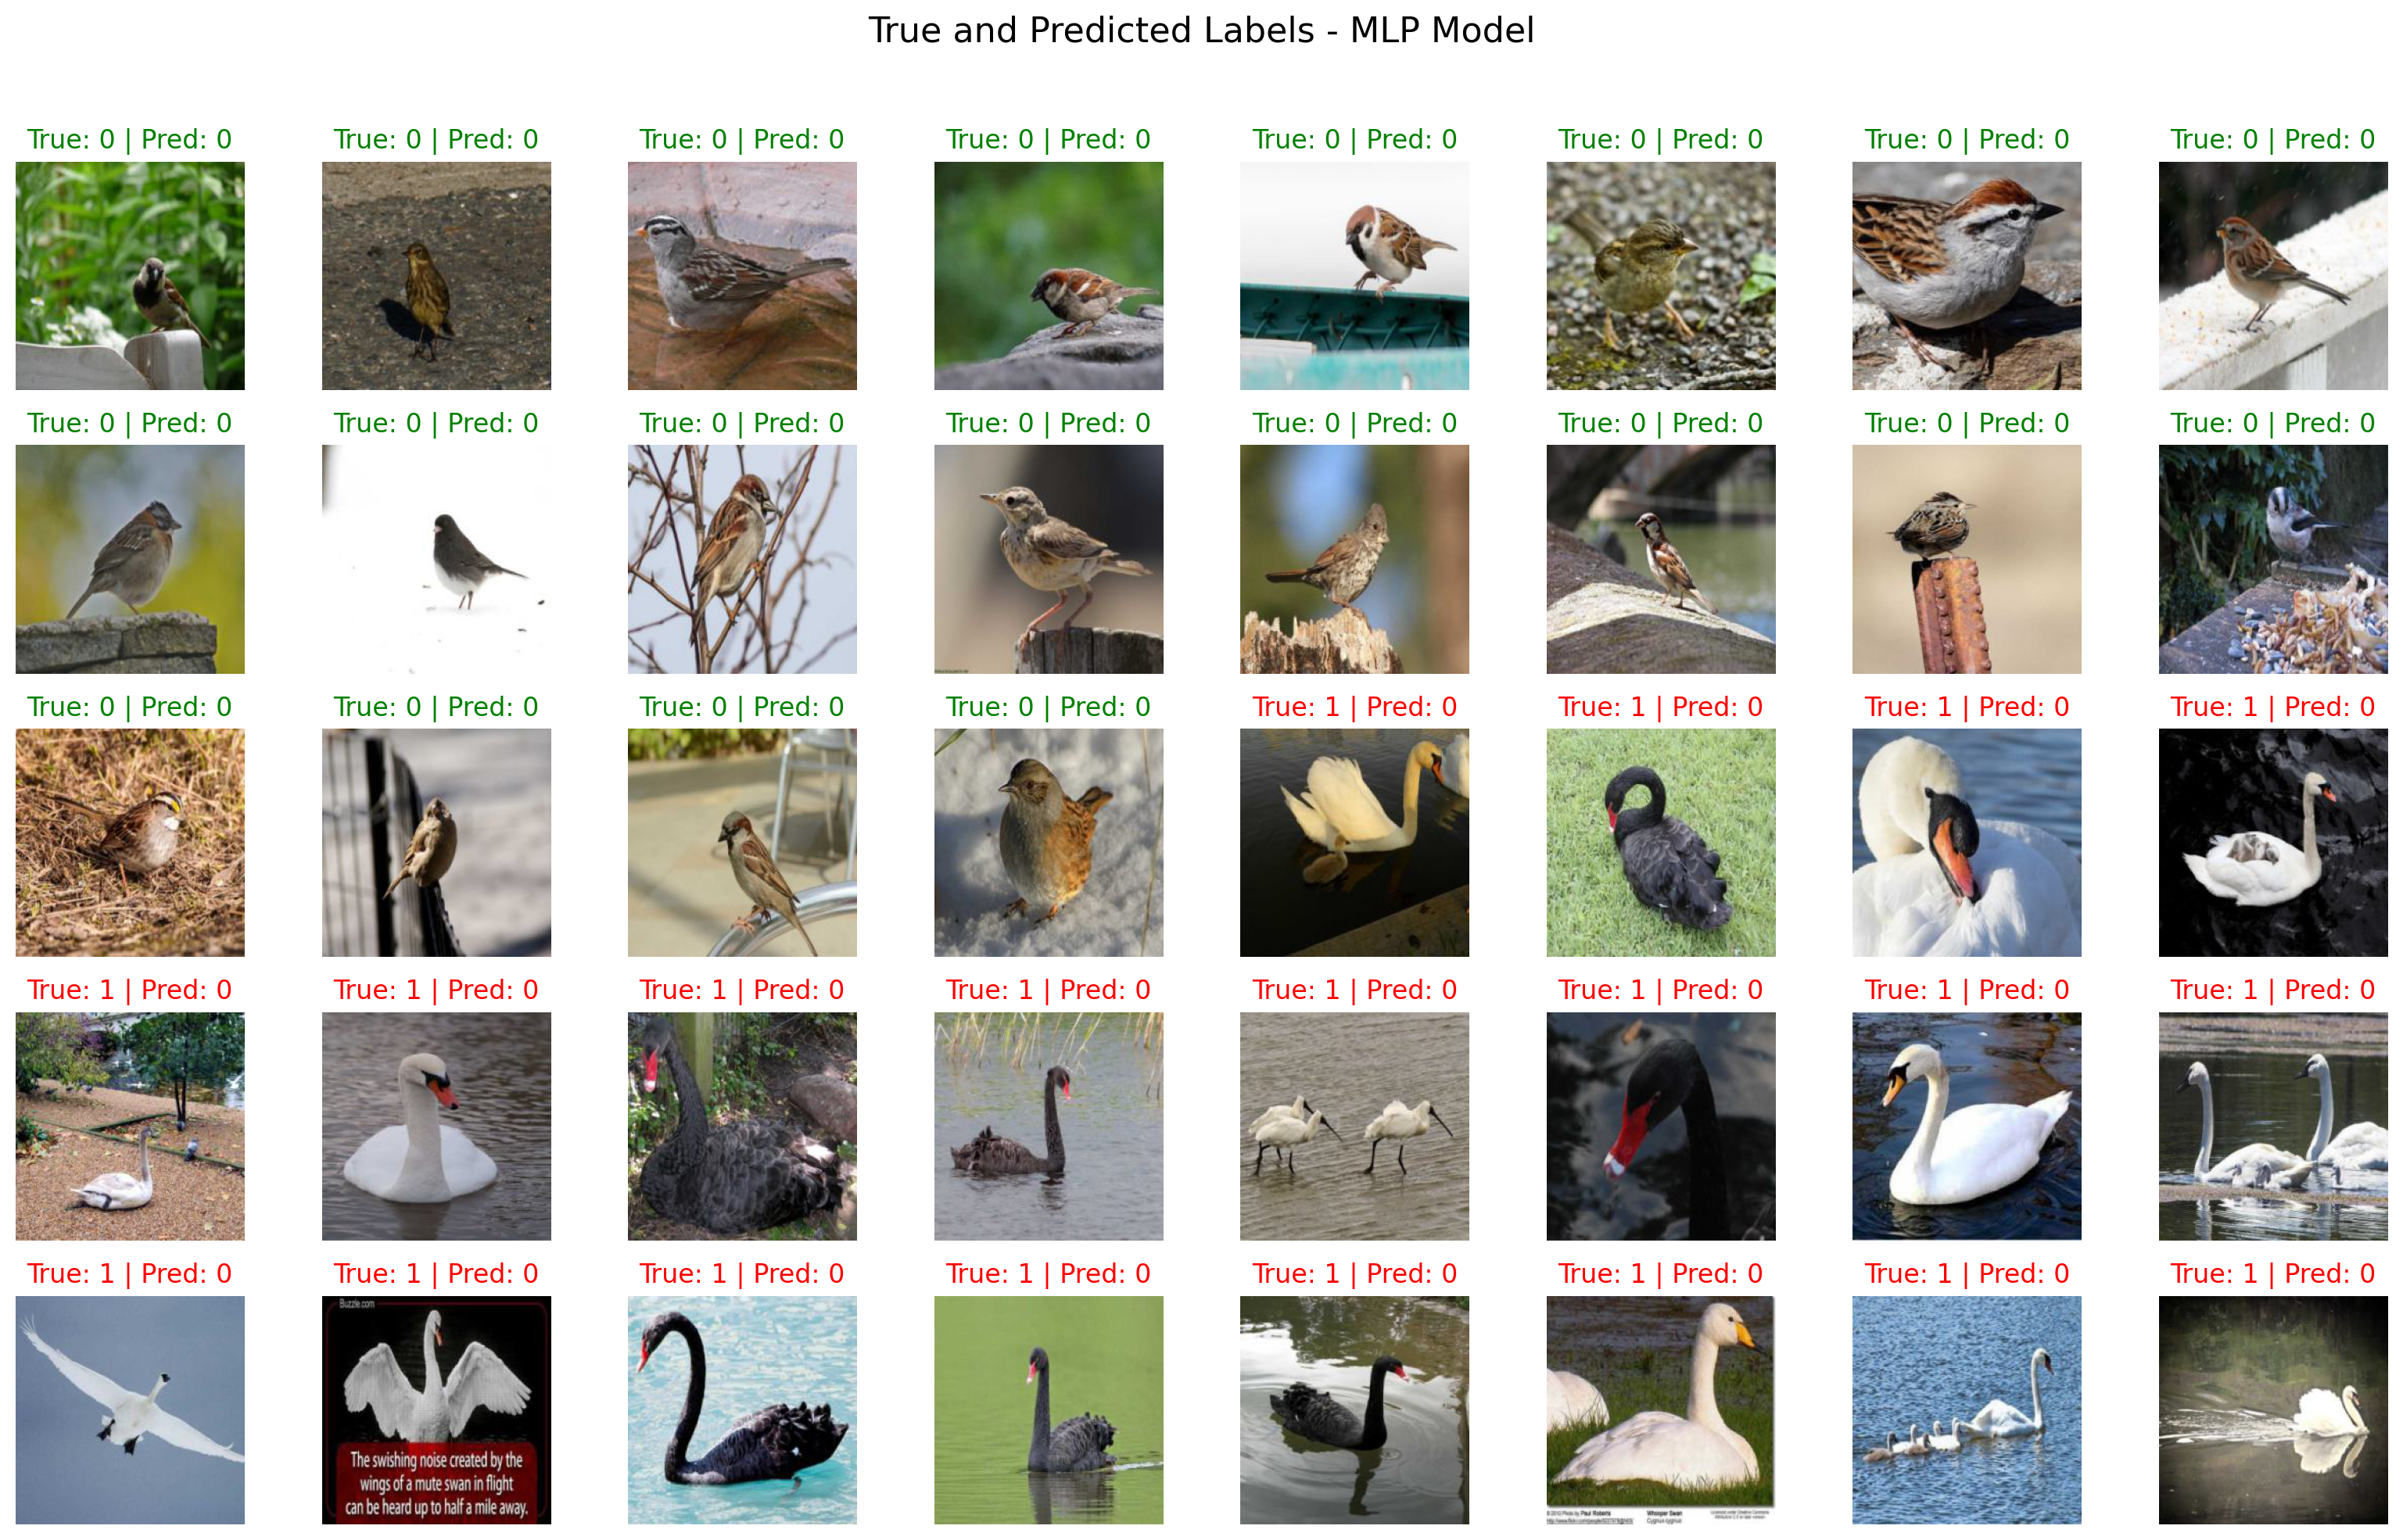

In [15]:
# Plot the test predictions grid
true_labels, predicted_labels = plot_test_predictions_grid(model, test_loader, num_images=40, grid_size=(5, 8), title_suffix="MLP Model", device=device)

### Conclusion Based on Comparing the MLP Model and VGG16/VGG19 Performance:

The performance difference between the **MLP model** and the **VGG16/VGG19 models** with **transfer learning** highlights several key aspects of **model architecture** and **transfer learning**:

1. **Model Architecture**:
   - The **MLP (Multilayer Perceptron)** is a **fully connected neural network** and typically struggles with image classification tasks, especially when working with high-dimensional input like images. In comparison to **VGG16/VGG19**, which are **convolutional neural networks (CNNs)**, MLPs lack the spatial invariance and ability to learn hierarchical features from images. 
   - The **VGG16** and **VGG19 models** have multiple convolutional layers that can capture spatial hierarchies, edges, textures, and other essential features from images, making them much more suited for image-based tasks. When using **transfer learning**, these pre-trained models benefit from the knowledge gained from large-scale image datasets (such as ImageNet), allowing them to achieve much higher accuracy (97-100%) on your task.

2. **Transfer Learning**:
   - **VGG16/VGG19 with transfer learning** leverages the knowledge of pre-trained models on large, diverse datasets (like ImageNet), making them **highly effective** for new tasks. The convolutional filters learned in earlier layers are applicable to a wide variety of visual tasks, so the pre-trained features help to **reduce the training time** and improve performance on smaller datasets.
   - On the other hand, training an **MLP from scratch** on image data without the help of pre-trained features results in **poorer performance**. This is because MLPs don't inherently capture spatial information from the image data.

3. **Parameter Comparison**:
   - **VGG16** has a significantly larger number of parameters (about 138 million) compared to the MLP model we created. The larger number of parameters in CNNs, especially those with deep architectures like VGG16/VGG19, enables them to learn more complex features from the images. However, simply increasing the number of parameters in an MLP doesn't necessarily mean better performance unless the architecture is better suited for the task (e.g., convolutional layers for image tasks).
   
4. **Training Complexity**:
   - **VGG16/VGG19** with transfer learning is more computationally expensive during training but achieves better performance due to the use of pre-trained weights. MLPs, though lighter and faster to train, are not inherently designed for visual data, so they require much more extensive training to achieve good results.

### Conclusion:
- **MLPs are not well-suited for image classification tasks** as they lack the ability to learn spatial hierarchies present in images. In contrast, **CNNs like VGG16 and VGG19 are optimized for visual tasks**, and their performance can be enhanced significantly using **transfer learning**.
- While an MLP can be adjusted with a large number of parameters, **convolutional networks inherently perform better on image classification**, especially when leveraging **pre-trained models**.

The key takeaway is that for tasks involving image data, convolutional neural networks (like VGG16) with **transfer learning** generally outperform **fully connected MLPs** in terms of accuracy and training efficiency.